In [2]:
pip install mp-api

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.9/211.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.2/122.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.4 MB/s eta 0:00:00
   ━━━━

In [16]:
import csv
import pandas as pd

numerical_df = pd.read_csv("/content/cleaned_numerical_data.csv")

numerical_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155361 entries, 0 to 155360
Data columns (total 45 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   nsites                                        155361 non-null  int64  
 1   nelements                                     155361 non-null  int64  
 2   volume                                        155361 non-null  float64
 3   density                                       155361 non-null  float64
 4   density_atomic                                155361 non-null  float64
 5   deprecated                                    155361 non-null  int64  
 6   energy_per_atom                               152149 non-null  float64
 7   formation_energy_per_atom                     152149 non-null  float64
 8   energy_above_hull                             152149 non-null  float64
 9   is_stable                                     15

In [17]:
#split data into real and theoretical subsets model on real values first

numerical_df.drop(['deprecated'], axis=1, inplace=True)

real_df = numerical_df[numerical_df['theoretical'] == 0].copy()
theoretical_df = numerical_df[numerical_df['theoretical'] == 1].copy()

real_df.drop(['theoretical'], axis=1, inplace=True)
theoretical_df.drop(['theoretical'], axis=1, inplace=True)

print("Real df shape:", real_df.shape)
print("Theoretical df shape:", theoretical_df.shape)

Real df shape: (49772, 43)
Theoretical df shape: (105589, 43)


In [5]:
real_df['band_gap'].describe()

#Note, band_gap is not normally distributed and is skewed right

,band_gap
count,49772.000000
mean,1.341899
std,1.739477
min,0.000000
25%,0.000000
50%,0.265150
75%,2.443400
max,17.891400


In [6]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49772 entries, 36 to 155336
Data columns (total 43 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   nsites                                        49772 non-null  int64  
 1   nelements                                     49772 non-null  int64  
 2   volume                                        49772 non-null  float64
 3   density                                       49772 non-null  float64
 4   density_atomic                                49772 non-null  float64
 5   energy_per_atom                               48674 non-null  float64
 6   formation_energy_per_atom                     48674 non-null  float64
 7   energy_above_hull                             48674 non-null  float64
 8   is_stable                                     49772 non-null  int64  
 9   equilibrium_reaction_energy_per_atom          23056 non-null  fl

In [25]:
real_df["energy_above_hull"]

,energy_above_hull
36,0.089671
37,0.008550
38,0.036314
39,0.012841
40,0.008192
...,...
154904,0.196555
154998,0.238527
155205,0.022104
155239,0.026298


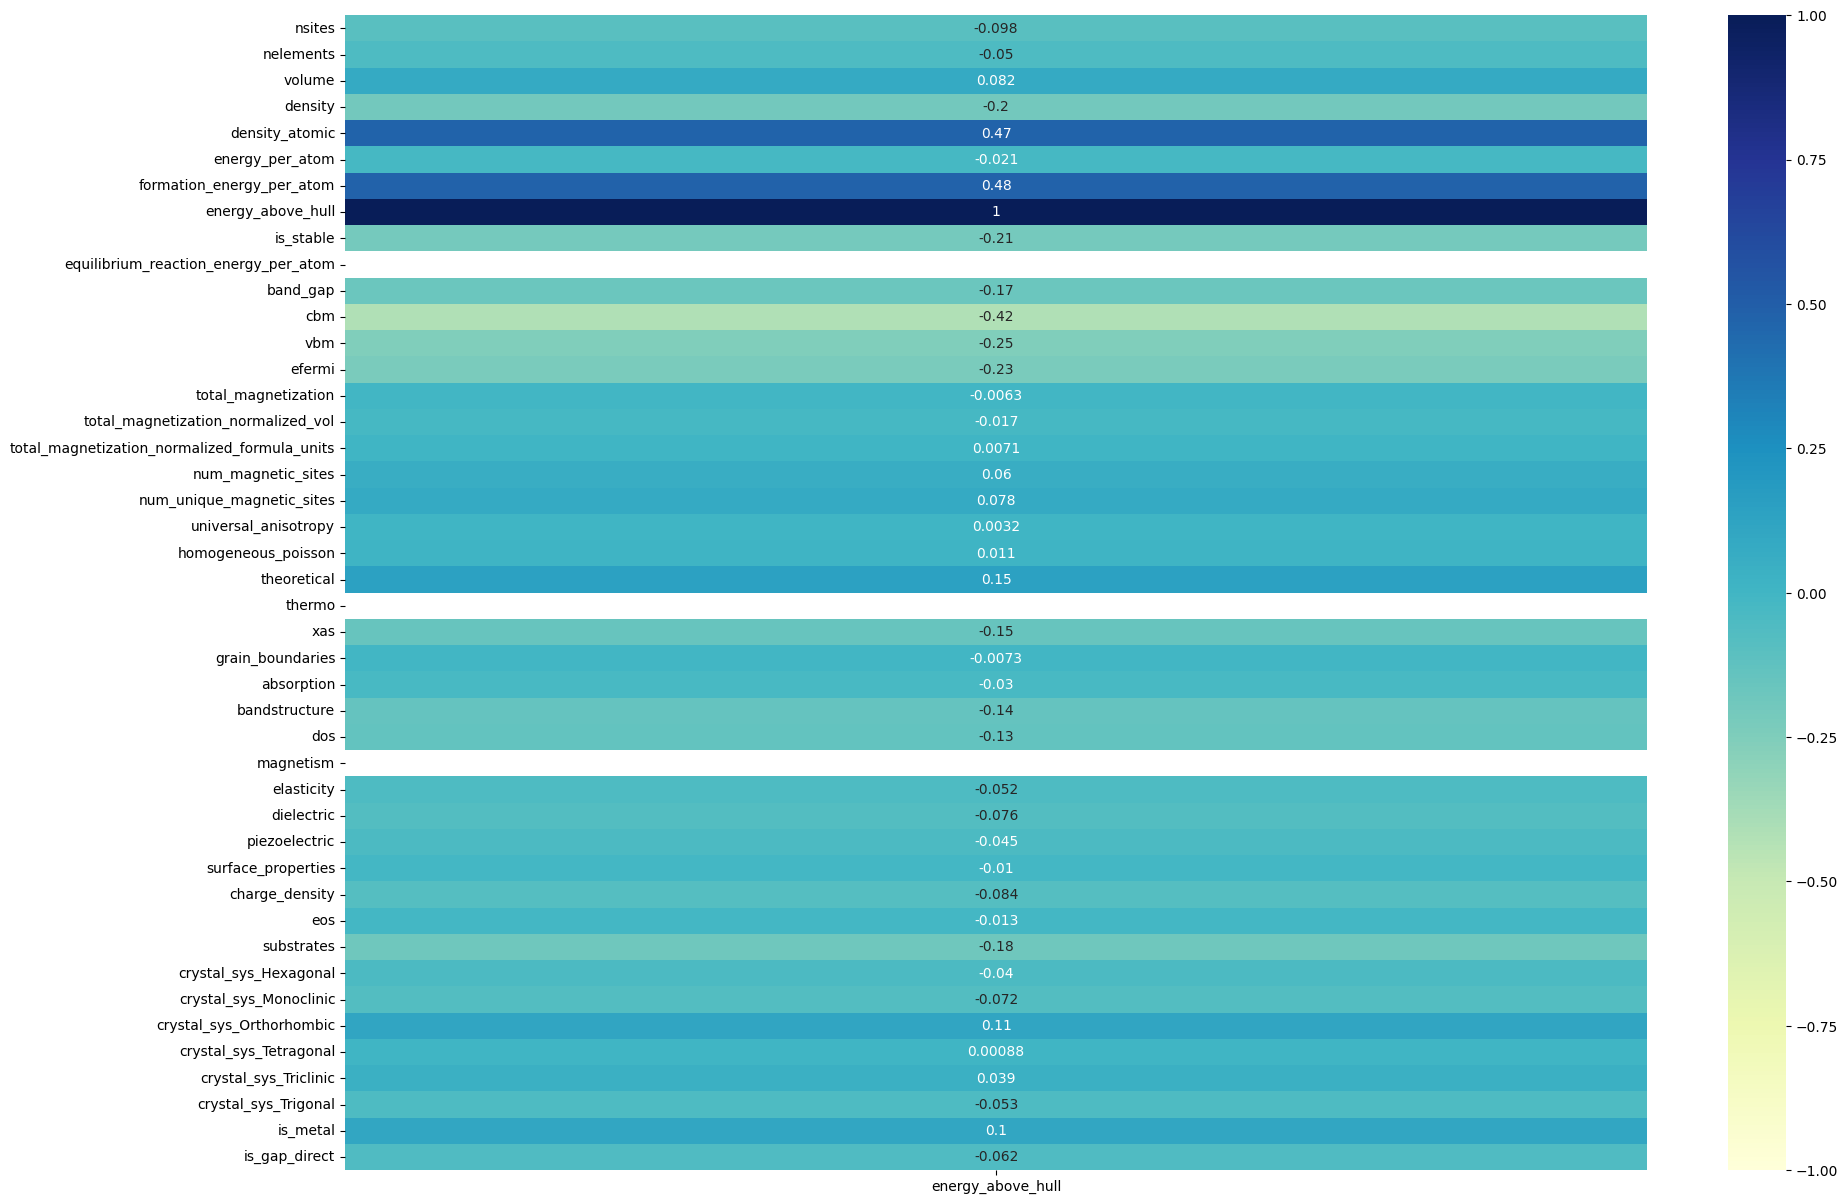

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(21, 15))
corr_matrix = numerical_df.corr()

corr_band_gap = corr_matrix[['energy_above_hull']]
sns.heatmap(corr_band_gap, annot=True, cmap="YlGnBu", vmin=-1, vmax=1)

plt.show()

In [76]:
#Train a model for band_gap on real molecules

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

# Create the list of features to train with below
feature_names = ["density_atomic", "cbm", "is_stable", "crystal_sys_Orthorhombic","bandstructure", "dos",
                 "energy_per_atom", "is_metal","efermi" ,"vbm" ,"formation_energy_per_atom","density"]

# numerical_df[feature_names].isnull().sum()

filtered_null_counts = numerical_df.loc[numerical_df['theoretical'] == 1, feature_names].isnull().sum()

print(filtered_null_counts)


density_atomic                   0
cbm                          43644
is_stable                        0
crystal_sys_Orthorhombic         0
bandstructure                    0
dos                              0
energy_per_atom               2114
is_metal                         0
efermi                          17
vbm                          43644
formation_energy_per_atom     2114
density                          0
dtype: int64


In [77]:
X = real_df[feature_names]

y = real_df["energy_above_hull"]

train_X, test_x, train_y, test_y = train_test_split(X, y, train_size = 0.2, random_state=1)

dtr_model = DecisionTreeRegressor(random_state=1)

dtr_model.fit(train_X, train_y)

predictions = dtr_model.predict(test_x)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_y, predictions)

# mean squared error (MSE) and R-squared (R2)
mse = mean_squared_error(test_y, predictions)
r2 = r2_score(test_y, predictions)

print("Mean Squared Error: ", mse)
print("R-squared: ", r2)
print("Mean Absolute Error: ", mae)

Mean Squared Error:  0.027600767358695922
R-squared:  0.4852367399767351
Mean Absolute Error:  0.05950834432045469


In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

#Check for and handle categorical variables
label_encoder = LabelEncoder()

# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=200, random_state=42, oob_score=True)
# train_X, val_X, train_y, val_y
regressor.fit(train_X, train_y)
# Fit the regressor with x and y data

RandomForestRegressor(n_estimators=200, oob_score=True, random_state=42)

In [79]:
# Evaluating the model against the test set
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# Access the OOB Score
# OOB Score is the number of correctly predicted data on OOB samples taken for validation, you want less than 1%
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
# train_X, test_x, train_y, test_y
# Making predictions on the same data or new data
predictions = regressor.predict(test_x)

# Evaluating the model
mse = mean_squared_error(test_y, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(test_y, predictions)
print(f'R-squared: {r2}')

# using mae, mean absolute error, or the average error, we can see on average how far off our # model is

mae = mean_absolute_error(test_y, predictions)
print("Mean Absolute Error: ", mae)

Out-of-Bag Score: 0.7155792490783726
Mean Squared Error: 0.013576188545869597
R-squared: 0.7467996819167952
Mean Absolute Error:  0.045921796977744164


In [59]:
theoretical_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103475 entries, 0 to 155360
Data columns (total 43 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   nsites                                        103475 non-null  int64  
 1   nelements                                     103475 non-null  int64  
 2   volume                                        103475 non-null  float64
 3   density                                       103475 non-null  float64
 4   density_atomic                                103475 non-null  float64
 5   energy_per_atom                               103475 non-null  float64
 6   formation_energy_per_atom                     103475 non-null  float64
 7   energy_above_hull                             103475 non-null  float64
 8   is_stable                                     103475 non-null  int64  
 9   equilibrium_reaction_energy_per_atom          10675 n

In [60]:
# Replace NaN values in the entire DataFrame with the mean of each column
theoretical_df[feature_names] = theoretical_df[feature_names].fillna(theoretical_df[feature_names].mean())
theoretical_df = theoretical_df.dropna(subset=['energy_above_hull'])

ValueError: Columns must be same length as key

In [66]:
#Now predict band-gap with the theoretical elements with Random Forrest Regressor


theoretical_x = theoretical_df[feature_names]
theoretical_y = theoretical_df['energy_above_hull']

theoretical_predictions = regressor.predict(theoretical_x)

# Evaluating the model
mse = mean_squared_error(theoretical_y, theoretical_predictions)
mae = mean_absolute_error(theoretical_y, theoretical_predictions)
r2 = r2_score(theoretical_y, theoretical_predictions)

print(f'Mean Squared Error: {mse}')
print("Mean Absolute Error: ", mae)
print(f'R-squared: {r2}')

Mean Squared Error: 0.0666170744531101
Mean Absolute Error:  0.12049436886331276
R-squared: 0.7567849747329874
